In [63]:
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
#%env TF_GPU_ALLOCATOR=cuda_malloc_async

env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/


In [64]:
import os
print(os.environ["LD_LIBRARY_PATH"])

$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/


In [65]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, models, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, TimeDistributed, LSTM, SpatialDropout2D, concatenate
from tensorflow.keras.optimizers import SGD, Adam

In [66]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [67]:
from tensorflow.python.client import device_lib

print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2022-11-24 21:21:44.450846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 21:21:44.451179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 21:21:44.451366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 21:21:44.451604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 21:21:44.451789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## Read the csv dataset to get the values for stage and discharge of the images

In [68]:
df = pd.read_csv("../../dataset/2012_2019_PlatteRiverWeir_features_merged_all.csv")
df.head()

Unnamed: 0           SensorTime          CaptureTime  \
0           0  2012-06-09 13:15:00  2012-06-09T13:09:07   
1           1  2012-06-09 13:15:00  2012-06-09T13:10:29   
2           2  2012-06-09 13:45:00  2012-06-09T13:44:01   
3           3  2012-06-09 14:45:00  2012-06-09T14:44:30   
4           4  2012-06-09 15:45:00  2012-06-09T15:44:59   

                                 Filename Agency  SiteNumber TimeZone  Stage  \
0  StateLineWeir_20120609_Farrell_001.jpg   USGS     6674500      MDT   2.99   
1  StateLineWeir_20120609_Farrell_002.jpg   USGS     6674500      MDT   2.99   
2  StateLineWeir_20120609_Farrell_003.jpg   USGS     6674500      MDT   2.96   
3  StateLineWeir_20120609_Farrell_004.jpg   USGS     6674500      MDT   2.94   
4  StateLineWeir_20120609_Farrell_005.jpg   USGS     6674500      MDT   2.94   

   Discharge        CalcTimestamp  ...  WeirPt2X  WeirPt2Y  WwRawLineMin  \
0      916.0  2020-03-11T16:58:28  ...        -1        -1           0.0   
1      916.0  2020-03-11T16:58:33  ...        -1        -1           0.0   
2      873.0  2020-03-11T16:58:40  ...        -1        -1           0.0   
3      846.0  2020-03-11T16:58:47  ...        -1        -1           0.0   
4      846.0  2020-03-11T16:58:55  ...        -1        -1           0.0   

   WwRawLineMax  WwRawLineMean  WwRawLineSigma  WwCurveLineMin  \
0           0.0            0.0             0.0             0.0   
1           0.0            0.0             0.0             0.0   
2           0.0            0.0             0.0             0.0   
3           0.0            0.0             0.0             0.0   
4           0.0            0.0             0.0             0.0   

   WwCurveLineMax  WwCurveLineMean  WwCurveLineSigma  
0             0.0              0.0               0.0  
1             0.0              0.0               0.0  
2             0.0              0.0               0.0  
3             0.0              0.0               0.0  
4             0.0              0.0               0.0  

[5 rows x 60 columns]

In [69]:
#df = df[["Filename", "Stage", "Discharge", 'SensorTime', "RiverArea", "RiverWidth"]]
df = df[["Filename", "Stage", "Discharge", 'SensorTime']]

In [70]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df.head()

Filename  Stage  Discharge  \
0  StateLineWeir_20120609_Farrell_001.jpg   2.99      916.0   
1  StateLineWeir_20120609_Farrell_002.jpg   2.99      916.0   
2  StateLineWeir_20120609_Farrell_003.jpg   2.96      873.0   
3  StateLineWeir_20120609_Farrell_004.jpg   2.94      846.0   
4  StateLineWeir_20120609_Farrell_005.jpg   2.94      846.0   

           SensorTime  Year  
0 2012-06-09 13:15:00  2012  
1 2012-06-09 13:15:00  2012  
2 2012-06-09 13:45:00  2012  
3 2012-06-09 14:45:00  2012  
4 2012-06-09 15:45:00  2012

In [71]:
df = df.sort_values(by="SensorTime", ascending=True)
df.head()

Filename  Stage  Discharge  \
0  StateLineWeir_20120609_Farrell_001.jpg   2.99      916.0   
1  StateLineWeir_20120609_Farrell_002.jpg   2.99      916.0   
2  StateLineWeir_20120609_Farrell_003.jpg   2.96      873.0   
3  StateLineWeir_20120609_Farrell_004.jpg   2.94      846.0   
4  StateLineWeir_20120609_Farrell_005.jpg   2.94      846.0   

           SensorTime  Year  
0 2012-06-09 13:15:00  2012  
1 2012-06-09 13:15:00  2012  
2 2012-06-09 13:45:00  2012  
3 2012-06-09 14:45:00  2012  
4 2012-06-09 15:45:00  2012

### Remove outliers

In [72]:
df = df[df.Stage > 0]
df = df[df.Discharge > 0]

We consider values equal to 0 as outliers because from the photos it doesn't seem that it would be possible that at this time we would have a value of 0 for stage or discharge

In [73]:
df.shape

(40148, 5)

### Scale the data

In [74]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from joblib import load

scaler = RobustScaler()
#scaler = load('std_scaler.joblib') # scaler with all the 42059 observations

Scale the data based only on the training dataset (in this case the training dataset is from 2012 to 2016)

In [75]:
#data_to_scale_fit = df[(df["Year"] >= 2012) & (df["Year"] <= 2016)][["Stage", "Discharge"]]
data_to_scale_fit = df[(df["Year"] >= 2012) & (df["Year"] <= 2016)][["Discharge"]]
data_to_scale_fit

Discharge
0          916.0
1          916.0
2          873.0
3          846.0
4          846.0
...          ...
21416      279.0
21417      279.0
21418      279.0
21419      279.0
21420      279.0

[20304 rows x 1 columns]

In [76]:
scaler.fit(data_to_scale_fit)


RobustScaler()

In [77]:
#df[["Stage", "Discharge"]] = scaler.transform(df[["Stage", "Discharge"]])
#df[["Discharge"]] = scaler.transform(df[["Discharge"]])
df

Filename  Stage  Discharge  \
0      StateLineWeir_20120609_Farrell_001.jpg   2.99      916.0   
1      StateLineWeir_20120609_Farrell_002.jpg   2.99      916.0   
2      StateLineWeir_20120609_Farrell_003.jpg   2.96      873.0   
3      StateLineWeir_20120609_Farrell_004.jpg   2.94      846.0   
4      StateLineWeir_20120609_Farrell_005.jpg   2.94      846.0   
...                                       ...    ...        ...   
42054  StateLineWeir_20191011_Farrell_409.jpg   2.54      434.0   
42055  StateLineWeir_20191011_Farrell_410.jpg   2.54      434.0   
42056  StateLineWeir_20191011_Farrell_411.jpg   2.54      434.0   
42057  StateLineWeir_20191011_Farrell_412.jpg   2.54      434.0   
42058  StateLineWeir_20191011_Farrell_413.jpg   2.54      434.0   

               SensorTime  Year  
0     2012-06-09 13:15:00  2012  
1     2012-06-09 13:15:00  2012  
2     2012-06-09 13:45:00  2012  
3     2012-06-09 14:45:00  2012  
4     2012-06-09 15:45:00  2012  
...                   ...   ...  
42054 2019-10-11 09:00:00  2019  
42055 2019-10-11 10:00:00  2019  
42056 2019-10-11 11:00:00  2019  
42057 2019-10-11 12:00:00  2019  
42058 2019-10-11 12:45:00  2019  

[40148 rows x 5 columns]

In [78]:
df.describe()

Stage     Discharge          Year
count  40148.000000  40148.000000  40148.000000
mean       2.903601   1017.063288   2016.168228
std        0.814612   1200.944046      1.997968
min        1.370000      6.730000   2012.000000
25%        2.280000    226.000000   2015.000000
50%        2.600000    451.500000   2016.000000
75%        3.320000   1390.000000   2018.000000
max        6.490000   7920.000000   2019.000000

In [79]:
from joblib import dump
#dump(scaler, 'std_scaler_train_value_0_outliers.joblib')

## Create the dataset pipeline

In [80]:
#IMG_SIZE = 224
IMG_SIZE = 320
BATCH_SIZE = 8
FRAMES = 10

In [81]:
from dataset_transformer import make_dataset_with_time, make_dataset, make_dataset_and_time

from dataset_transformer_2 import Dataset, Dataloader

In [82]:
path = "../../dataset/images_tmp_draw_sky"

#train_ds, train_size, val_ds, val_size, test_ds, test_size = make_dataset_and_time(path, BATCH_SIZE, IMG_SIZE, FRAMES, df, 10, True, "cnn")

train_dataset = Dataset(
    path,
    df[(df.Year >= 2012) & (df.Year <= 2016)],
    classes=[0, 1], 
)

# Dataset for validation images
val_dataset = Dataset(
    path,
    df[(df.Year >= 2017) & (df.Year <= 2017)],
    classes=[0, 1], 
)

test_dataset = Dataset(
    path,
    df[(df.Year >= 2018) & (df.Year <= 2019)],
    classes=[0, 1],
    shuffle=False
)

train_ds = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_ds = Dataloader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_ds = Dataloader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [83]:
input_shape = 0
output_shape = 0

for i in range(0, 1):
    image_time, stage_discharge = test_ds[i]
    #print(np.array(image_time).shape)
    
    image = image_time["input_1"]
    stage_discharge = stage_discharge
    #print(stage_discharge.shape)

    print(stage_discharge.shape)

    input_shape = image.shape[1:]
    #input_shape = image_time.numpy().shape[1:]
    output_shape = stage_discharge.shape[1:]

(8, 1)


In [84]:
print(input_shape)
print(output_shape)

(320, 320, 3)
(1,)


## Check images

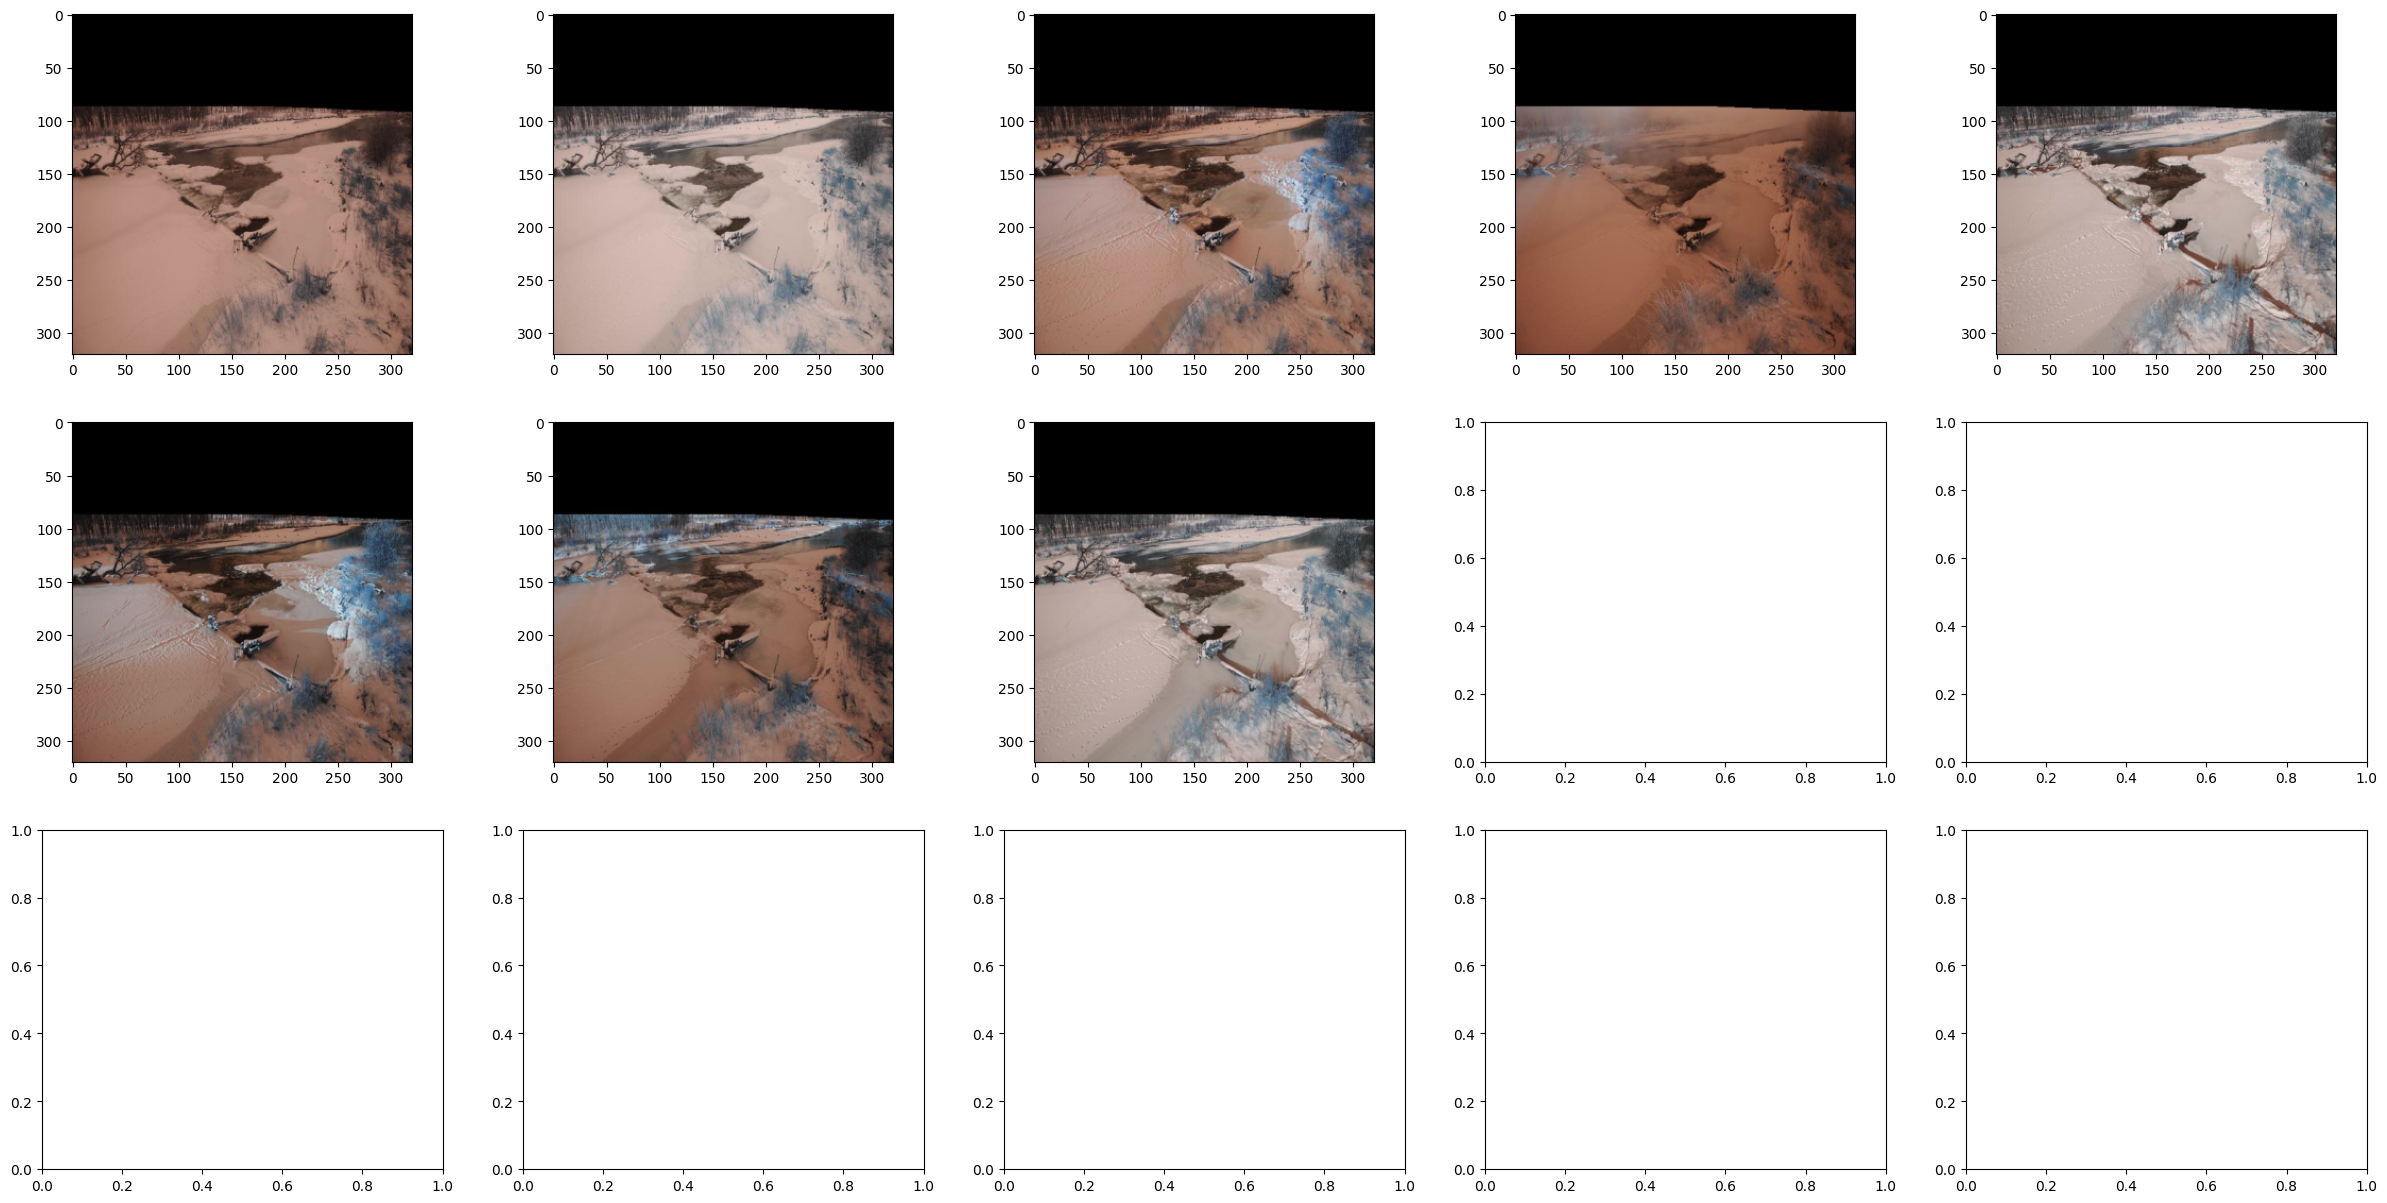

In [85]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))

for i in range(0, 1):
    image_time, stage_discharge = test_ds[i]
    images = image_time["input_1"]

    for img, ax in zip(images, ax.flatten()):
        #print(img.numpy()[:,:,3])
        #img = img.numpy()[:,:,:3]
        #img = img / 2 + 0.5     # unnormalize
        
        #print(img)
        ax.imshow(img)

plt.show()

## Create model

In [86]:
from scipy import ndimage as ndi
from skimage.filters import gabor_kernel

def sobel_kernel(shape, dtype=None):
    #print(shape)    
    sobel_x = tf.constant(
        [
            [-5, -4, 0, 4, 5], 
            [-8, -10, 0, 10, 8], 
            [-10, -20, 0, 20, 10], 
            [-8, -10, 0, 10, 8], 
            [-5, -4, 0, 4, 5]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (5, 5, 1, 1))

    #print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    #print(tf.shape(sobel_x))
    return sobel_x

def gfb_filter(shape, size=3, tlist=[1,2,3], slist=[2,5], flist=[0.01,0.25,0.5], dtype=None):
    print(shape)
    fsize=np.ones([size,size])
    kernels = []
    for theta in tlist:
        theta = theta / 4. * np.pi
        for sigma in slist:
            for frequency in flist:
                kernel = np.real(gabor_kernel(frequency, theta=theta,sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel)
    gfblist = []
    for k, kernel in enumerate(kernels):
        ck=ndi.convolve(fsize, kernel, mode='wrap')
        gfblist.append(ck)
    
    gfblist = np.asarray(gfblist).reshape(size,size,1,len(gfblist))
    gfblist = np.repeat(gfblist[:, :, :, :], gfblist.shape[1], axis=2)
    print(gfblist.shape)
    return tf.keras.backend.variable(gfblist, dtype='float32')


In [87]:
import segmentation_models as sm

seg_model = sm.Unet("resnet50", classes=1, activation="sigmoid")

seg_model.load_weights(
    f'model_weights/seg_model_resnet_50_1.hdf5')

In [88]:
from classification_models.keras import Classifiers

def create_model(input_shape, output_shape, option="normal"):
    model = Sequential()

    if option == "transfer":
        # Inputs
        input_base = Input(shape=input_shape, name="input_1")
        #time_area_input = Input(shape=(2), name="input_2")
        time_input = Input(shape=(1), name="input_2")


        base_model = tf.keras.applications.ResNet50V2(include_top=False,
                                                weights='imagenet',
                                                input_shape=input_shape)

        #base_model = ResNet34(include_top=False, weights='imagenet', input_shape=input_shape)
        
        for layer in base_model.layers:
            layer.trainable = False

        base_model._name = 'base_model_ResNet50V2'


        cnn_model = base_model(input_base)


        cnn_model = Dropout(0.5)(cnn_model)
        cnn_model = GlobalAveragePooling2D()(cnn_model)
        cnn_model = Dense(1024, activation="relu")(cnn_model)
        cnn_model = Dense(512, activation="relu")(cnn_model)

        #edge_detection = Conv2D(4, kernel_size=(5, 5), kernel_initializer=sobel_kernel, strides=(2, 2), activation='relu', trainable=False)

        #edge_detection = edge_detection(input_base)
        #edge_detection.trainable = False
        #edge_detection = GlobalAveragePooling2D()(edge_detection)
        #edge_detection = Dense(512, activation="elu")(edge_detection)
        #edge_detection = Dense(512, activation="elu")(edge_detection)
        
        """
        gfb = Conv2D(filters=18, kernel_size=3, kernel_initializer=gfb_filter, strides=1, padding='valid', trainable=False, name="Gabor_filter")
        gfb = gfb(input_base)
        gfb.trainable = False
        gfb = GlobalAveragePooling2D()(gfb)
        gfb = Dense(1024, activation="relu")(gfb)
        gfb = Dense(512, activation="relu")(gfb)
        """

        combined = concatenate([cnn_model, time_input], name="combined_model")
        #combined = BatchNormalization()(combined)

        cnn_time = Dense(513, activation="elu")(combined)
        #cnn_time = Dropout(0.3)(cnn_time)
        cnn_time = Dense(256, activation="elu")(cnn_time)
        #cnn_time = Dropout(0.3)(cnn_time)
        cnn_time = Dense(128, activation="elu")(cnn_time)
        cnn_time = Dense(64, activation="elu")(cnn_time)
        output = Dense(output_shape, activation='linear')(cnn_time)

        model = tf.keras.Model([input_base, time_input], output, name="cnn_segmentation")
    elif option == "normal":
        model.add(Input(shape=input_shape))
        
        """model.add(Conv2D(16, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(GlobalAveragePooling2D())

        model.add(Dense(512, activation='elu'))
        model.add(Dropout(0.3))
        model.add(Dense(512, activation='elu'))
        model.add(Dropout(0.3))
        model.add(Dense(256, activation='elu'))
        model.add(Dense(64, activation='elu'))"""

        model.add(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), padding='same', activation="elu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation="elu", padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same'))
        #model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(32, kernel_size=(3, 3), activation='elu'))

        model.add(Conv2D(32, kernel_size=(3, 3), activation='elu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, kernel_size=(2, 2), activation='elu'))

        model.add(Conv2D(64, kernel_size=(2, 2), activation='elu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(2048, activation='relu'))
        model.add(Dense(2048, activation='relu'))
        model.add(Dense(1024, activation='relu'))
        model.add(Dense(1024, activation='relu'))
        
    #model.add(Dense(output_shape, activation='linear')) # linear regression output layer

    return model


In [89]:
model = create_model(input_shape, output_shape[0], "transfer")

In [90]:
model.summary()

Model: "cnn_segmentation"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 base_model_ResNet50V2 (Functio  (None, 10, 10, 2048  23564800   ['input_1[0][0]']                
 nal)                           )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 10, 10, 2048  0           ['base_model_ResNet50V2[0][0]']  
                                )                                                  

In [91]:
def compile_model(loss_func, optimizer, metrics=["accuracy"]):
    model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)

In [92]:
import tensorflow_addons as tfa

In [93]:
sgd = SGD(learning_rate=0.01, decay=1e-3, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=1e-3, decay=1e-3 / 200)

"""compile_model(tfa.losses.PinballLoss(tau=.6), adam,  [
              'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])"""

"""compile_model(tf.keras.losses.Huber(), adam,  [
              'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])"""

compile_model("mse", adam,  [
              'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])

In [94]:
def fit_model(training_values, validation_values=None, epochs=10, steps=32, val_steps=32, callbacks=[]):
    return model.fit(training_values, validation_data=validation_values, epochs=epochs, steps_per_epoch=steps, validation_steps=val_steps, callbacks=callbacks)

In [95]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date_actual
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/{date_actual}_cnn_best_weights.hdf5",
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)


In [96]:
# batch_size = 0 because we already have batch size in tf dataset

model_h = fit_model(train_ds, val_ds, epochs=100, steps=len(train_ds), val_steps=len(val_ds), callbacks=[tensorboard_callback, checkpoint_callback, es_callback, tf.keras.callbacks.ReduceLROnPlateau(patience=5)])

#model.fit(train_ds, validation_data=val_ds, epochs=60, steps_per_epoch=len(train_ds), validation_steps=len(val_ds), callbacks=[tensorboard_callback, checkpoint_callback, es_callback, tf.keras.callbacks.ReduceLROnPlateau(patience=5)])

Epoch 1/100


2022-11-24 21:21:53.905353: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-24 21:21:55.199009: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-24 21:21:55.200399: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-24 21:21:55.200480: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-24 21:21:55.202030: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-24 21:21:55.202173: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-24 21:21:56.387001: W tensorflow/core/common_runtime/bf

2538/2538 [==============================] - ETA: 0s - loss: 3.1358 - mse: 3.1358 - rmse: 1.7708 - mae: 0.6604 - mape: 23.3414

2022-11-24 21:26:27.013064: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2022-11-24 21:26:27.218105: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.
2022-11-24 21:26:27.565439: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2022-11-24 21:26:27.940428: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2022-11-24 21:26:28.237012: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.14867, saving model to model_weights/20221124-212150_cnn_best_weights.hdf5
2538/2538 [==============================] - 278s 107ms/step - loss: 3.1358 - mse: 3.1358 - rmse: 1.7708 - mae: 0.6604 - mape: 23.3414 - val_loss: 0.1487 - val_mse: 0.1487 - val_rmse: 0.3856 - val_mae: 0.2858 - val_mape: 8.6893 - lr: 0.0010
Epoch 2/100
2538/2538 [==============================] - ETA: 0s - loss: 0.2386 - mse: 0.2386 - rmse: 0.4884 - mae: 0.3452 - mape: 11.8577
Epoch 2: val_loss did not improve from 0.14867
2538/2538 [==============================] - 261s 103ms/step - loss: 0.2386 - mse: 0.2386 - rmse: 0.4884 - mae: 0.3452 - mape: 11.8577 - val_loss: 0.7105 - val_mse: 0.7105 - val_rmse: 0.8429 - val_mae: 0.7684 - val_mape: 24.2654 - lr: 0.0010
Epoch 3/100
2538/2538 [==============================] - ETA: 0s - loss: 0.1895 - mse: 0.1895 - rmse: 0.4353 - mae: 0.2996 - mape: 10.2114
Epoch 3: val_loss did not improve from 0.14867
2538/2538 [=================

## Evaluate model

In [97]:
print(date_actual)

20221124-212150


In [98]:
best_model = models.load_model(f'model_weights/{date_actual}_cnn_best_weights.hdf5', custom_objects={"gfb_filter": gfb_filter, "sobel_kernel": sobel_kernel})
#best_model = models.load_model(f'model_weights/{date_actual}_cnn_best_weights.hdf5', custom_objects={"gfb_filter": gfb_filter, "sobel_kernel": sobel_kernel})
#best_model = models.load_model(f'best_models_weights/cnn_best_weights_v9.hdf5')


In [99]:
def evaluate_model(model, test_values, steps):
  score = model.evaluate(test_values, steps=steps)
  return score

In [100]:
test_loss, test_mse, test_rmse, test_mae, test_mape = evaluate_model(best_model, test_ds, steps=len(test_ds))

1590/1590 [==============================] - 125s 78ms/step - loss: 0.0764 - mse: 0.0764 - rmse: 0.2765 - mae: 0.1920 - mape: 7.2211


In [101]:
#predictions = best_model.predict(test_ds, steps=np.ceil(test_size / BATCH_SIZE))

In [102]:
for i in range(0, 1):
	image_time, stage_discharge = test_ds[i]
	predictions = best_model.predict(x=image_time)

	stage_discharge_test_values = stage_discharge
	predictions_values = predictions
	
	diff = predictions_values.flatten() - stage_discharge_test_values.flatten()
	percentDiff = (diff / stage_discharge_test_values.flatten()) * 100
	absPercentDiff = np.abs(percentDiff)
	# compute the mean and standard deviation of the absolute percentage
	# difference
	mean = np.mean(absPercentDiff)
	std = np.std(absPercentDiff)
	# finally, show some statistics on our model
	print(mean)
	print(std)

	stage_discharge_test_values = stage_discharge[:10]
	#stage_discharge_test_values = stage_discharge_test_values.numpy().reshape(10, 2)
	stage_discharge_test_values = stage_discharge_test_values
	predictions_values = predictions[:10]

	for i in range(len(stage_discharge_test_values)):
		#print(f"pred discharge: {scaler.inverse_transform(predictions_values)[i][0]}, actual discharge: {scaler.inverse_transform(stage_discharge_test_values)[i][0]}")

		print(f"pred discharge: {predictions_values[i][0]}, actual discharge: {stage_discharge_test_values[i][0]}")

1/1 [==============================] - 1s 558ms/step
20.16369887647422
6.370452618698775
pred discharge: 2.702657699584961, actual discharge: 2.31
pred discharge: 3.1361827850341797, actual discharge: 2.41
pred discharge: 3.2976913452148438, actual discharge: 2.67
pred discharge: 2.985496997833252, actual discharge: 2.43
pred discharge: 2.824427843093872, actual discharge: 2.42
pred discharge: 3.294461250305176, actual discharge: 2.71
pred discharge: 3.3241004943847656, actual discharge: 2.71
pred discharge: 2.9496421813964844, actual discharge: 2.76


### Residual analysis

In [103]:
y_predictions = np.empty(shape=(1, 1)).astype('float32')
y_real = np.empty(shape=(1, 1)).astype('float32')
images_worst_values = []

for i in range(0, 200):
    image, stage_discharge = test_ds[i]
    y_predictions = np.concatenate((y_predictions, best_model.predict(x=image)))
    y_real = np.concatenate((y_real, stage_discharge))
    #images_worst_values.append(image.numpy())

1/1 [==============================] - 0s 20ms/step


#### Check what values are the worst performers

In [104]:
#images_worst_values = np.array(images_worst_values)
#images_worst_values.shape

In [105]:
#images_worst_values = images_worst_values.reshape(4800, 224, 224, 3)

In [106]:
residuals_for_images = np.abs(y_real - y_predictions).flatten()
#y_predictions_for_images = scaler.inverse_transform(y_predictions)
#y_real_for_images = scaler.inverse_transform(y_real)

y_predictions_for_images = y_predictions
y_real_for_images = y_real

indexes_for_images_worst_pred = np.argpartition(residuals_for_images, -100)[-100:]

print(list(zip(y_real_for_images[indexes_for_images_worst_pred].flatten(), y_predictions_for_images[indexes_for_images_worst_pred].flatten())))

[(2.18, 2.5269356), (2.27, 2.635438), (2.24, 2.6096306), (2.19, 2.5422087), (2.29, 2.6377006), (2.18, 2.5397024), (2.18, 2.5495067), (2.47, 2.8356583), (2.29, 2.6392765), (2.39, 2.7411487), (2.27, 2.6264033), (2.44, 2.8122158), (2.18, 2.5798666), (2.28, 2.6636162), (2.28, 2.6761484), (2.18, 2.5531464), (2.27, 2.6444752), (2.28, 2.6635847), (2.39, 2.7908657), (2.19, 2.5948944), (2.42, 2.8244278), (2.18, 2.5530977), (2.31, 2.7026577), (2.47, 2.8835475), (2.27, 3.1142735), (2.19, 2.8399186), (2.32, 2.9565291), (2.47, 2.9347396), (2.27, 3.0880105), (2.28, 2.9873357), (2.27, 3.2136233), (2.28, 3.1591783), (2.32, 2.9565291), (2.32, 2.9565291), (2.48, 3.0917397), (2.18, 2.918531), (2.28, 2.723957), (2.3, 2.8993068), (2.32, 2.9565291), (2.27, 2.8480225), (2.27, 3.1610374), (2.32, 2.9565291), (2.2, 2.873129), (2.32, 2.9565291), (2.71, 3.2944613), (2.32, 2.9565291), (2.27, 2.8955636), (2.43, 2.985497), (2.28, 2.8446164), (2.67, 3.2976913), (2.28, 3.7275205), (2.19, 2.7117772), (2.17, 2.9545164),

In [107]:
"""fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(30, 20))

print_images_worst_values = images_worst_values[indexes_for_images_worst_pred]

for img, ax in zip(print_images_worst_values[:30], ax.flatten()):
    img = img / 2 + 0.5     # unnormalize
    ax.imshow(img)

plt.show()"""

'fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(30, 20))\n\nprint_images_worst_values = images_worst_values[indexes_for_images_worst_pred]\n\nfor img, ax in zip(print_images_worst_values[:30], ax.flatten()):\n    img = img / 2 + 0.5     # unnormalize\n    ax.imshow(img)\n\nplt.show()'

#### Check residuals

0.1602437853494115


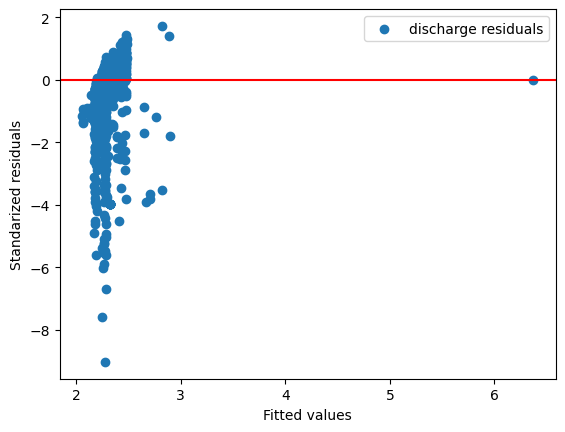

In [108]:
residuals = y_real - y_predictions
residuals_std = residuals/residuals.std()

#y_real_stage = np.array([i[0] for i in y_real])
#residual_stage = np.array([i[0] for i in residuals])

y_real_discharge = np.array([i[0] for i in y_real])
residual_discharge = np.array([i[0] for i in residuals])

print(residual_discharge.std())

#plt.scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
plt.scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel("Fitted values")
plt.ylabel("Standarized residuals")

plt.legend()
plt.show()

In [109]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

#figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

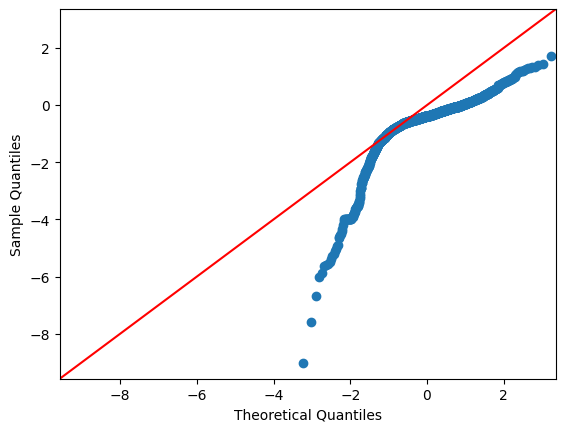

In [110]:
figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')
plt.show()

In [111]:
"""plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()"""

"plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)\nplt.ylabel('Count')\nplt.xlabel('Residual stage');\nplt.show()"

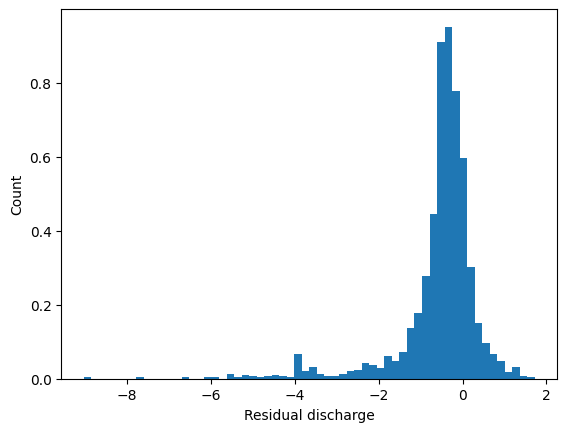

In [112]:
plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()

In [113]:
"""stat, pval = normal_ad(residual_stage)
print("p-value:", pval)

if pval<0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")"""

'stat, pval = normal_ad(residual_stage)\nprint("p-value:", pval)\n\nif pval<0.05:\n    print("Hay evidencia de que los residuos no provienen de una distribución normal.")\nelse:\n    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")'

In [114]:
stat, pval = normal_ad(residual_discharge / residual_discharge.std())
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


## Visualize layers

In [115]:
layer_outputs = [layer.output for layer in best_model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=best_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "conv1_pad". The following previous layers were accessed without issue: []

In [ ]:
activations = activation_model.predict(test_ds.take(1)) 

1/1 [==============================] - 0s 369ms/step


conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
conv2d_3
conv2d_4
max_pooling2d_2
conv2d_5
conv2d_6
max_pooling2d_3


MemoryError: Unable to allocate 91.1 GiB for an array with shape (331776, 36864) and data type float64

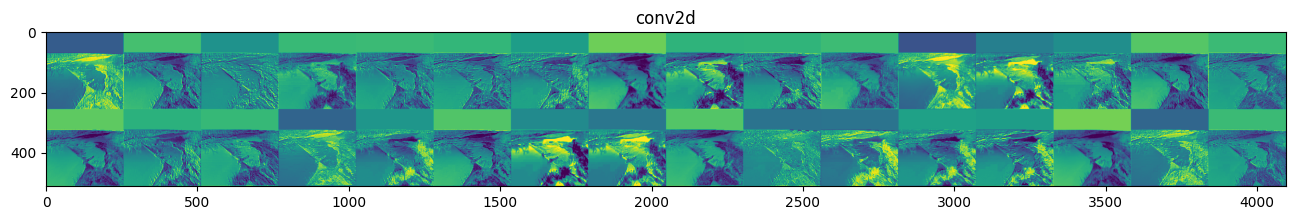

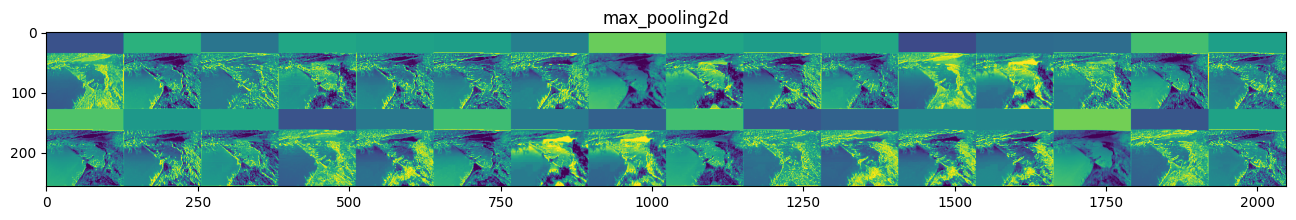

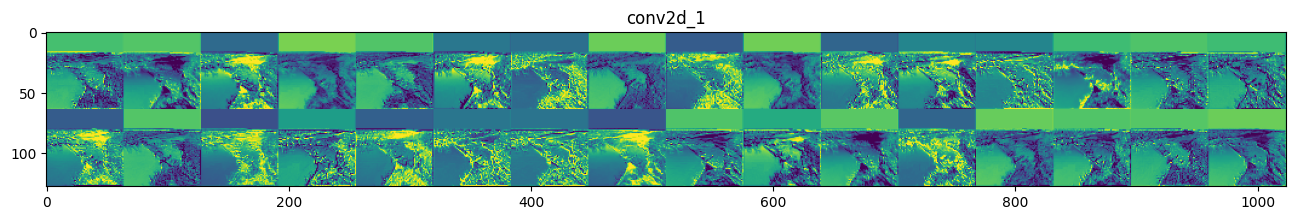

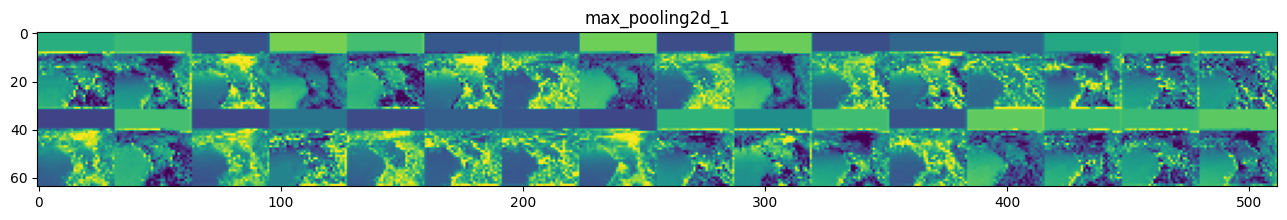

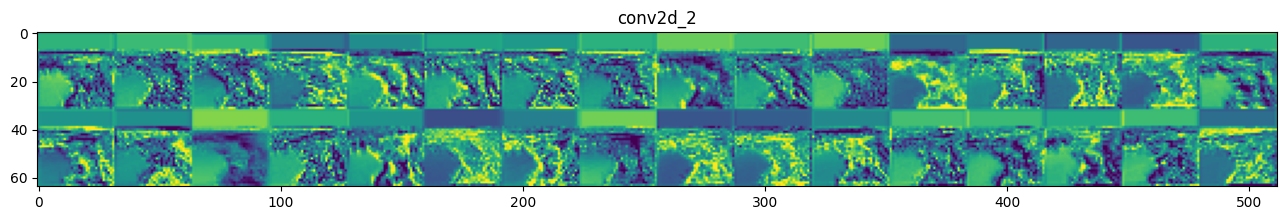

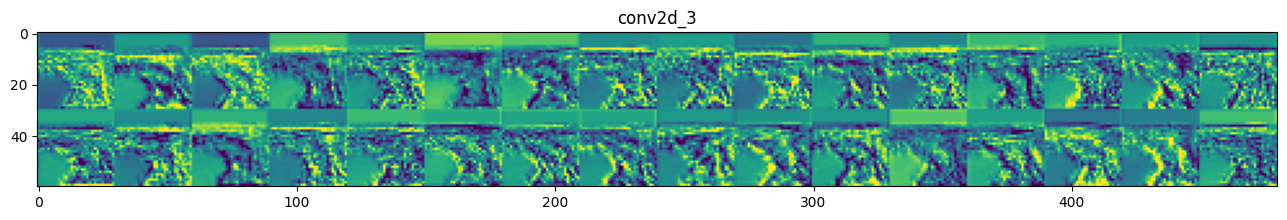

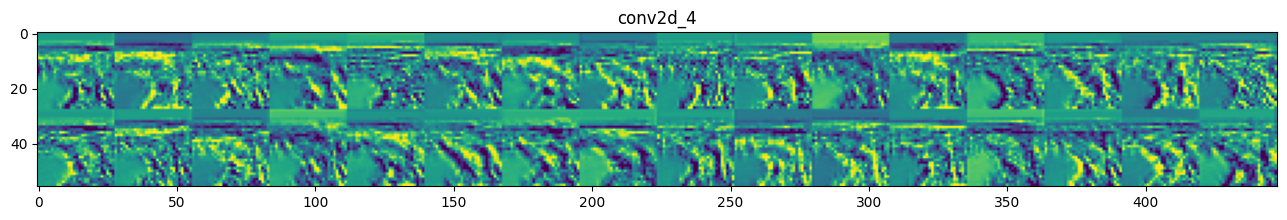

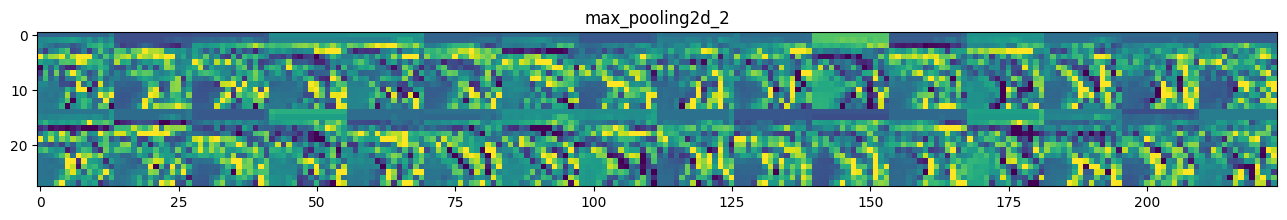

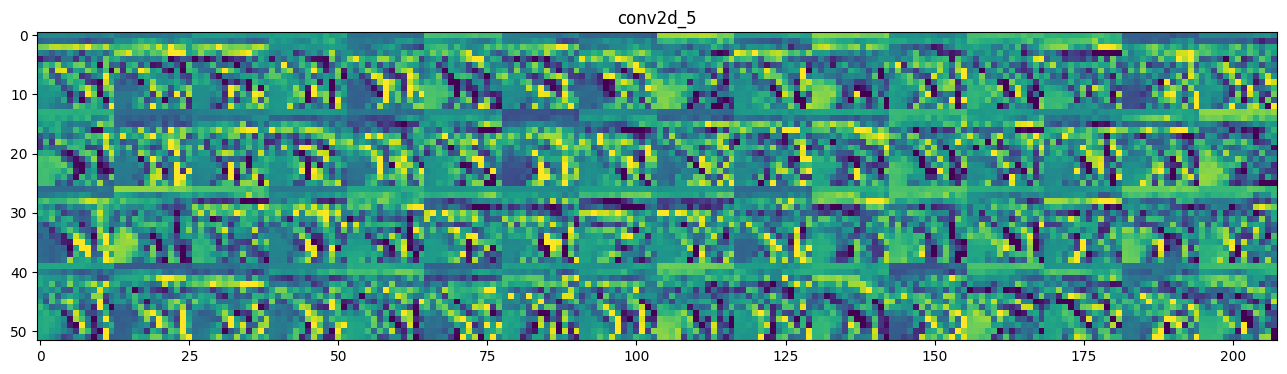

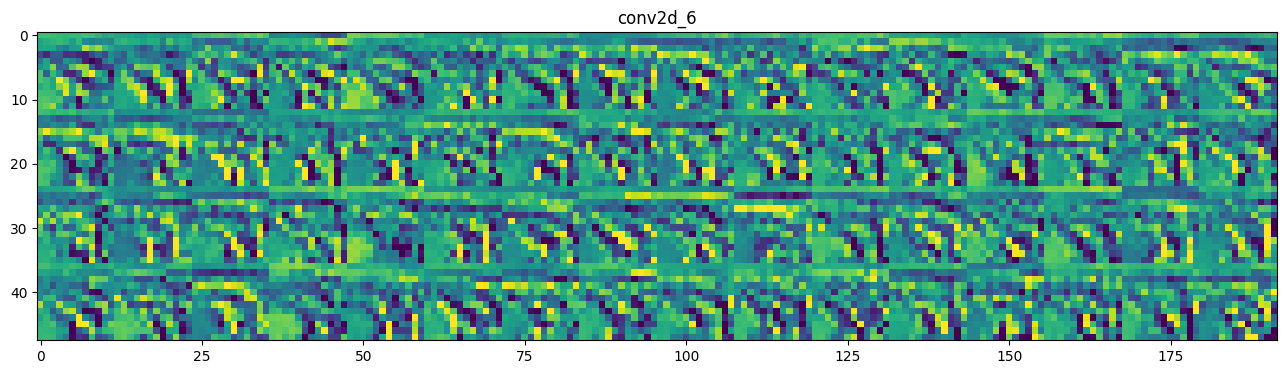

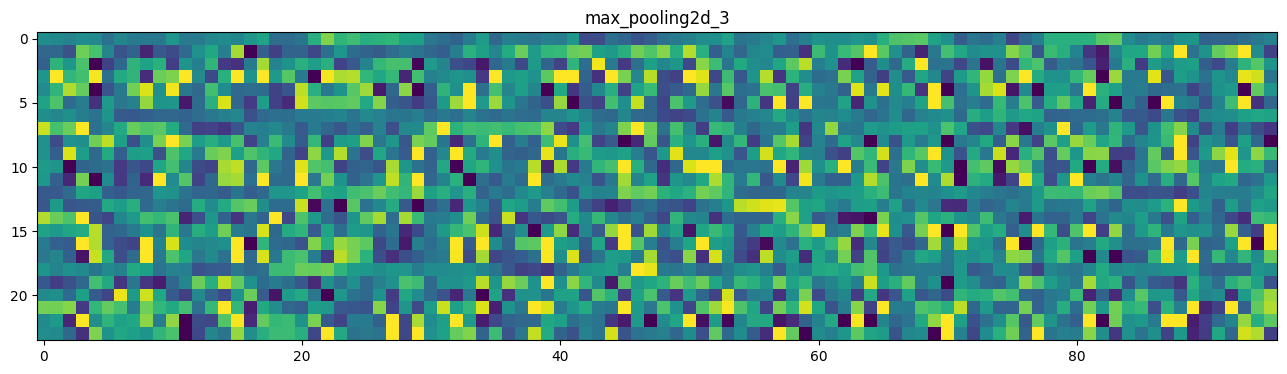

In [ ]:
import matplotlib.pyplot as plt

layer_names = []
for layer in best_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    print(layer_name)
    if "flatten" in layer_name or "dense" in layer_name: break

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')